In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import gsw
import xgcm

### Barotropic Transport Streamfunction
The barotropic velocity can be used to calculate the barotropic streamfunction, defined via

$u_b=-\frac{\partial \psi}{\partial y}$, $v_b=\frac{\partial \psi}{\partial x}$.

### Preparation

In [2]:
datadir = '/data/data_pub/SODA3.3.1/soda3.3.1_mn_ocean_reg_1980.nc'
ds = xr.open_dataset(datadir)

xx, yy = np.meshgrid(ds.longitude, ds.latitude)

dx2d = gsw.distance(xx, yy, 0) 
dy2d = gsw.distance(yy, xx, 0)

dz = np.arange(50)

for i in np.arange(50):
    if i ==0:
        dz[i] = ds.depth[0] * 2
    dz[i] = (ds.depth[i].values - np.sum(dz[:i])) * 2
    
dz3d = np.zeros((50, 330, 720))
dz2d = np.zeros((50, 330))
for i in np.arange(330):
    dz2d[:, i] = dz
for i in np.arange(720):
    dz3d[:, :, i] = dz2d
    
lat1 = 180; lat2 = 230; lon1 = 240; lon2 = 520
lat3 = 180; lat4 = 230; lon3 = 560; lon4 = 710


mask = np.ones((330, 720))
mask[np.isnan(ds.temp[0, 0, :, :])==1] = np.nan

In [3]:
ds

<xarray.Dataset>
Dimensions:          (depth: 50, latitude: 330, longitude: 720, time: 12)
Coordinates:
  * time             (time) float32 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
  * latitude         (latitude) float32 -74.75 -74.25 -73.75 ... 89.25 89.75
  * longitude        (longitude) float32 0.25 0.75 1.25 ... 358.8 359.2 359.8
  * depth            (depth) float32 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
Data variables:
    temp             (time, depth, latitude, longitude) float32 ...
    salt             (time, depth, latitude, longitude) float32 ...
    wt               (time, depth, latitude, longitude) float32 ...
    ssh              (time, latitude, longitude) float32 ...
    mlt              (time, latitude, longitude) float32 ...
    mlp              (time, latitude, longitude) float32 ...
    mls              (time, latitude, longitude) float32 ...
    anompb           (time, latitude, longitude) float32 ...
    net_heating      (time, latitude, longitude) float32 ...
    salt_flux_total  (time, latitude, longitude) float32 ...
    prho             (time, depth, latitude, longitude) float32 ...
    u                (time, depth, latitude, longitude) float32 ...
    v                (time, depth, latitude, longitude) float32 ...
    taux             (time, latitude, longitude) float32 ...
    tauy             (time, latitude, longitude) float32 ...
Attributes:
    Title:                         SODA3.3.1 ocean state
    Institution:                   University of Maryland
    Website:                       http://www.soda.umd.edu
    Acknowledgement:               The SODA3 project is funded by the US Nati...
    Created_by:                    Gennady Chepurin and Ligang Chen
    Creation_date:                 October, 2016
    Principle_investigator:        James A. Carton
    Principle_investigator_email:  carton@atmos.umd.edu

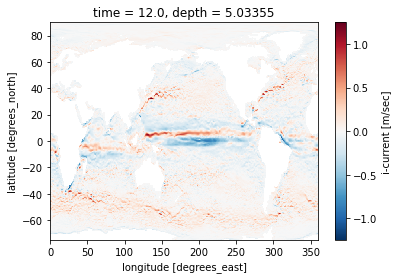

In [6]:
ds.u[-1, 0, :, :].plot()

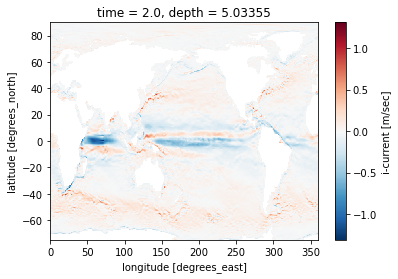

In [7]:
ds.u[1, 0, :, :].plot()

### Calculation

In [45]:
sf_np = np.zeros((36, 180, 719))
sf_na = np.zeros((36, 180, 719))

kk = 0

for year in np.arange(1990, 2016, 1):
    
    datadir = '/data/data_pub/SODA3.3.1/soda3.3.1_mn_ocean_reg_' + str(year) + '.nc'
    ds = xr.open_dataset(datadir)
    
    data1 = -(ds.u.mean('time') * dz3d).sum('depth')[:, :-1] * dy2d
    data2 = (ds.v.mean('time') * dz3d).sum('depth')[:, :-1] * dx2d * mask[:, :-1]
    
    sf_np[kk, :, :] = data2[150:, :].cumsum('longitude') / 10**6 
    sf_na[kk, :, :] = data2[150:, :].cumsum('longitude') / 10**6
    
    kk += 1

/data/home/liutongya/.conda/envs/geo_scipy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  "ignore", r"Mean of empty slice", category=RuntimeWarning


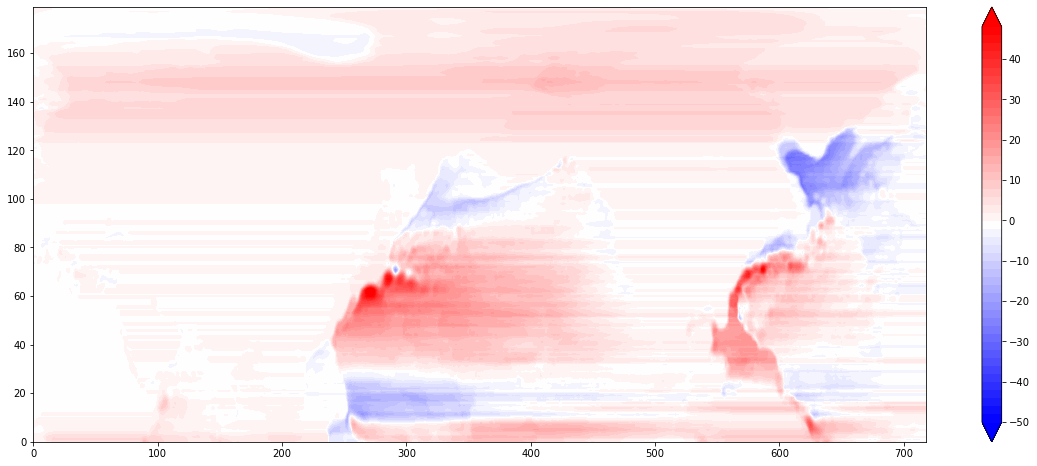

In [52]:
plt.figure(figsize=(20, 8))
plt.contourf(np.mean(sf_na, axis=0), np.arange(-50, 50, 2), extend='both', cmap='bwr')
plt.colorbar()

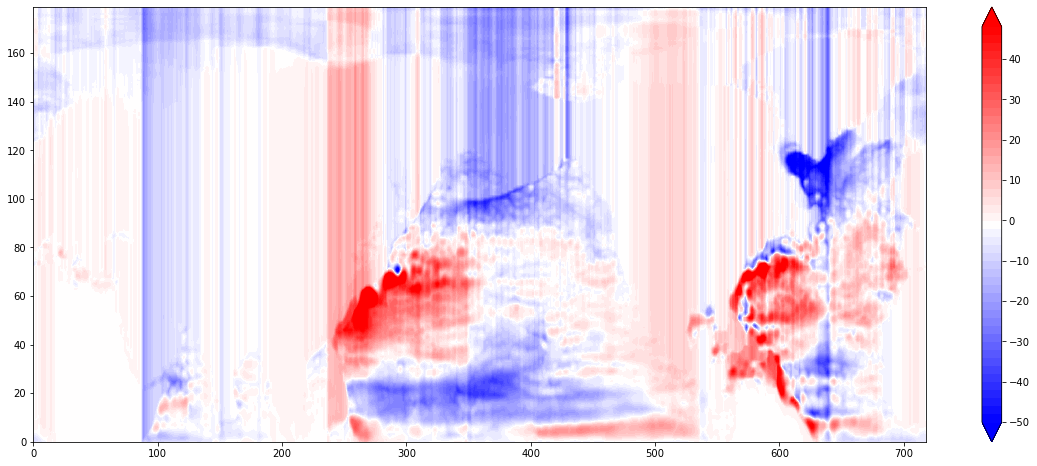

In [43]:
plt.figure(figsize=(20, 8))
plt.contourf(data1[150:, :].cumsum('latitude')/10**6, np.arange(-50, 50, 2), extend='both', cmap='bwr')
plt.colorbar()

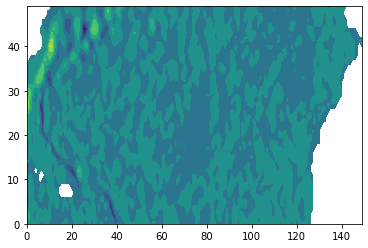

In [294]:
plt.contourf(data2[lat3:lat4, lon3:lon4])

In [297]:
tmp = data2[lat3:lat4, lon3:lon4]

tmp.shape

(50, 150)

In [298]:

tmp2 = np.zeros((50, 150))

In [299]:
for i in np.arange(150):
    tmp2[:, i] = np.nansum(tmp[:, i:], axis=1)

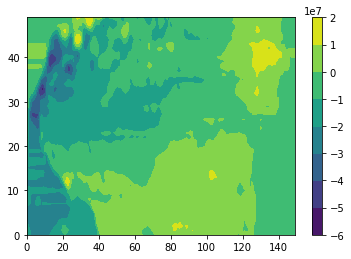

In [301]:
plt.contourf(tmp2)
plt.colorbar()

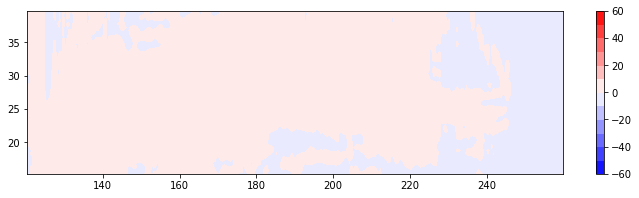

In [265]:
plt.figure(figsize=(12, 3))
plt.contourf(ds.longitude[lon1:lon2], ds.latitude[lat1:lat2], np.nanmean(sf_np, axis=0), np.arange(-60, 60.5, 10), vmin=-60, vmax=60, cmap='bwr')
plt.colorbar()

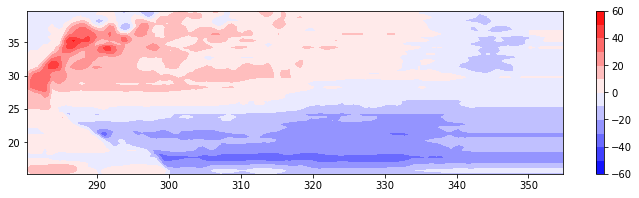

In [285]:
plt.figure(figsize=(12, 3))
plt.contourf(ds.longitude[lon3:lon4], ds.latitude[lat3:lat4], sf_na[0, :, :], np.arange(-60, 60.5, 10), vmin=-60, vmax=60, cmap='bwr')
plt.colorbar()

In [245]:
dz

array([ 10,  10,  10,  10,  11,   9,  12,   9,  13,   9,  14,  10,  15,
        13,  18,  16,  24,  23,  34,  35,  50,  54,  75,  81, 107, 113,
       139, 145, 166, 169, 187, 184, 199, 194, 206, 200, 209, 203, 212,
       204, 213, 205, 213, 206, 213, 207, 212, 208, 212, 208])

In [246]:
np.diff(ds.depth)

array([ 10.067101,  10.118701,  10.139101,  10.217899,  10.2869  ,
        10.398499,  10.5411  ,  10.774101,  11.046303,  11.472946,
        12.010498,  12.801903,  13.837997,  15.307205,  17.258698,
        19.9505  ,  23.514297,  28.290802,  34.48271 ,  42.457   ,
        52.3573  ,  64.361176,  78.256134,  93.7207  , 109.98895 ,
       126.30145 , 141.72174 , 155.6607  , 167.62097 , 177.56506 ,
       185.495   , 191.73096 , 196.46399 , 200.07104 , 202.71997 ,
       204.71411 , 206.14087 , 207.219   , 207.969   , 208.54712 ,
       208.93384 , 209.2461  , 209.43799 , 209.6128  , 209.70215 ,
       209.80322 , 209.83984 , 209.90186 , 209.91211 ], dtype=float32)

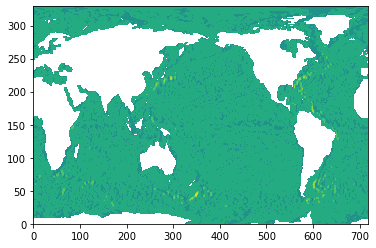

In [190]:
plt.contourf(data2)

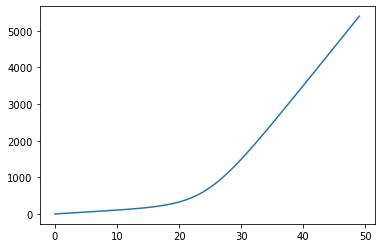

In [247]:
plt.plot(ds.depth)

In [27]:
(dd * ds.u.mean('time')[0, :, :-1]).cumsum('longitude')

<xarray.DataArray 'u' (latitude: 330, longitude: 719)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.67215178e+05, -2.67215178e+05, -2.67215178e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.81812104e+05, -4.81812104e+05, -4.81812104e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.24416083e+05, -5.24416083e+05, -5.24416083e+05],
       ...,
       [-1.02393821e+03, -2.05309732e+03, -3.12375858e+03, ...,
        -3.11773729e+04, -3.21991218e+04, -3.32258493e+04],
       [-1.13331675e+03, -2.26715346e+03, -3.40136536e+03, ...,
         4.68776970e+05,  4.67671083e+05,  4.66562305e+05],
       [ 2.83957669e-15,  5.67915337e-15,  8.51873006e-15, ...,
         2.03597648e-12,  2.03881606e-12,  2.04165564e-12]])
Coordinates:
  * latitude   (latitude) float32 -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25
    depth      flo

In [22]:
dd = gsw.distance(yy, xx, 0)

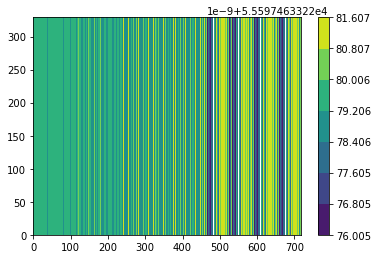

In [23]:
plt.contourf(dd)
plt.colorbar()

(0.0, 520.0)

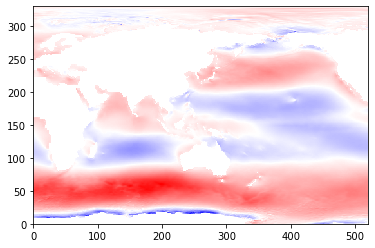

In [95]:
plt.pcolormesh(ds.taux.mean('time'), cmap='bwr')
plt.xlim(0, 520)

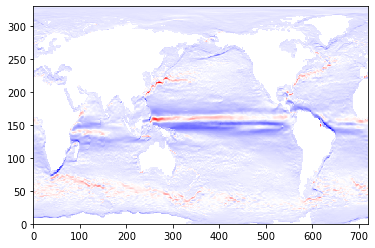

In [7]:
plt.pcolormesh(ds.u.mean('time')[0, :, :], cmap='bwr')

### Time series